# Cloud Generation

This notebook utilizes the satellite cloud generator published on GitHub by Czerkawski et al, 2023. The notebook takes inspiration from their notebooks and investigates the generation of three cloud groups.

Furthermore, it does so on the MasatiV2 dataset. The structure is the following:

- Think Clouds
- Thin Fog
- Testing: Parameter settings
- Cloud and Shadows

In [11]:
# Import necessary libraries
import satellite_cloud_generator as scg
import os
import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm

## Load Dataset

In [12]:
import torch
import numpy as np
from PIL import Image


def load_and_preprocess_image(image_path, target_size=(256, 256)):
    """
    Load and preprocess an image for cloud generation.

    Args:
        image_path (str): Path to the image file
        target_size (tuple): Desired output size (width, height)

    Returns:
        torch.Tensor: Preprocessed image as a PyTorch tensor in (C,H,W) format
    """
    # Load image
    img = Image.open(image_path)

    # Convert to RGB if necessary
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Resize image
    img = img.resize(target_size, Image.Resampling.LANCZOS)

    # Convert to numpy array and normalize to 0-1
    img_array = np.array(img) / 255.0

    # Convert to PyTorch tensor and rearrange dimensions from (H,W,C) to (C,H,W)
    img_tensor = torch.FloatTensor(img_array).permute(2, 0, 1)

    return img_tensor

def imshow(tensor,*args,**kwargs):
    plt.rcParams["figure.figsize"] = (12,6)
    while len(tensor.shape)>3:
        tensor=tensor[0]
    plt.imshow(tensor.permute(1,2,0).detach().cpu(),*args,**kwargs)

def plot_clouds(rgb_img, cl, cmask, smask=None):

    n_plots = 4 if smask is not None else 3

    plt.subplot(1,n_plots,1)
    imshow(rgb_img)
    plt.title('Input')
    plt.subplot(1,n_plots,2)
    imshow(cl)
    plt.title('Simulated')
    plt.subplot(1,n_plots,3)
    imshow(cmask)
    plt.title('Channel-wise Cloud Mask')
    plt.subplot(1,n_plots,n_plots)
    if smask is not None:
        imshow(smask)
        plt.title('Channel-wise Shadow Mask')

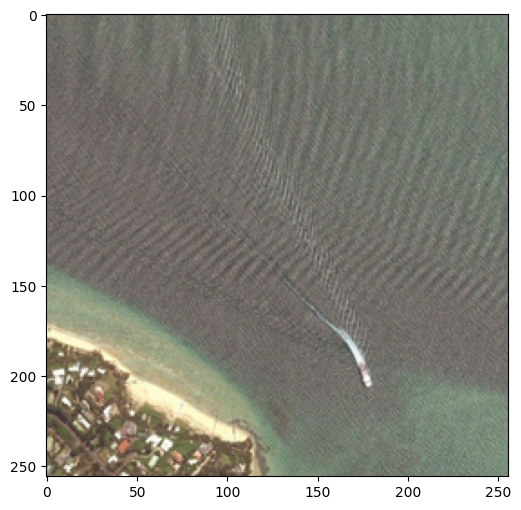

In [13]:
rgb_img = load_and_preprocess_image("C:/Users/20202016/Documents/Master/Master's Thesis/Datasets/MasatiV2/coast_ship/x0242.png")
imshow(rgb_img)

## Group 1: Thick Clouds

A basic cloud with max_lvl of ground component (1.0 guarantees some clear pixels) and min_lvl that controles the maximum value of cloud strength (1.0 guarantees some pixels with non-transparent cloud).

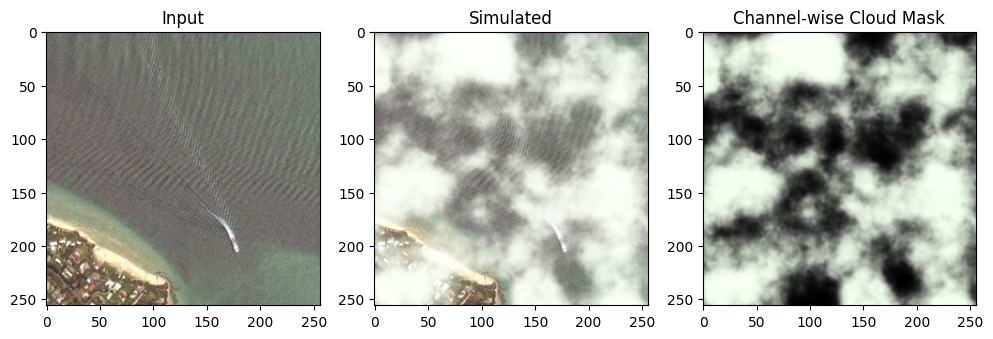

In [14]:
cl, mask = scg.add_cloud(rgb_img,
                         min_lvl=0.0,
                         max_lvl=1.0,
                         cloud_color=False,
                         channel_offset=0,
                         blur_scaling=0,
                         return_cloud=True,
                         const_scale=True,
                         noise_type='perlin')

plot_clouds(rgb_img, cl, mask)

## Group 2: Thin Fog

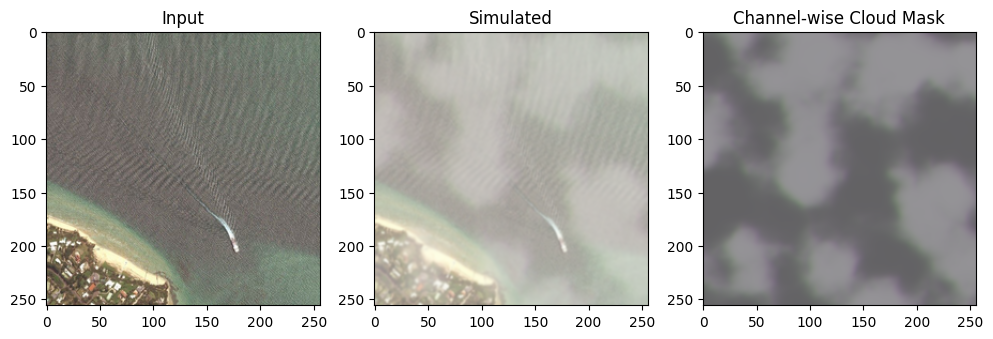

In [15]:
cl, mask = scg.add_cloud(rgb_img,
                     min_lvl=0.4,
                     max_lvl=0.6,
                     decay_factor=1.5,
                     return_cloud=True)

plot_clouds(rgb_img, cl, mask)

## Testing: Paramater Settings

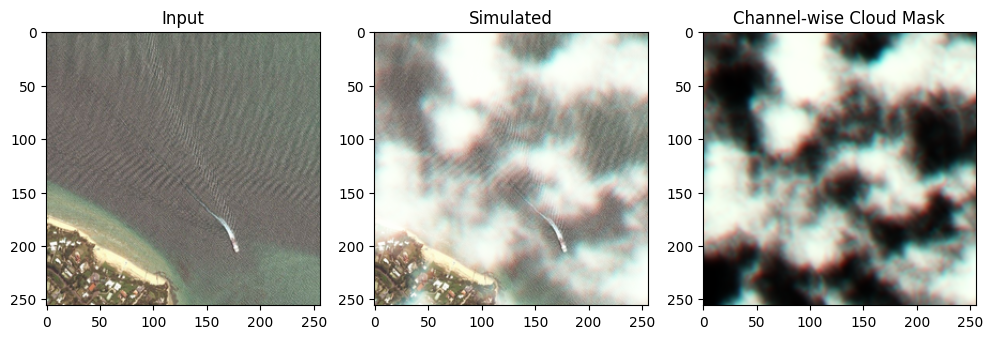

In [16]:
# The channel_offset setting controls the maximum positional offset in x or y direction between the channel-specific cloud masks and the base cloud mask (The value is sampled uniformly from the range [-channel_offset,+channel_offset]).
cl, mask = scg.add_cloud(rgb_img,
                     min_lvl=0.0,
                     max_lvl=1.0,
                     cloud_color=False,
                     channel_offset=3,
                     blur_scaling=0,
                     return_cloud=True
                    )

plot_clouds(rgb_img, cl, mask)

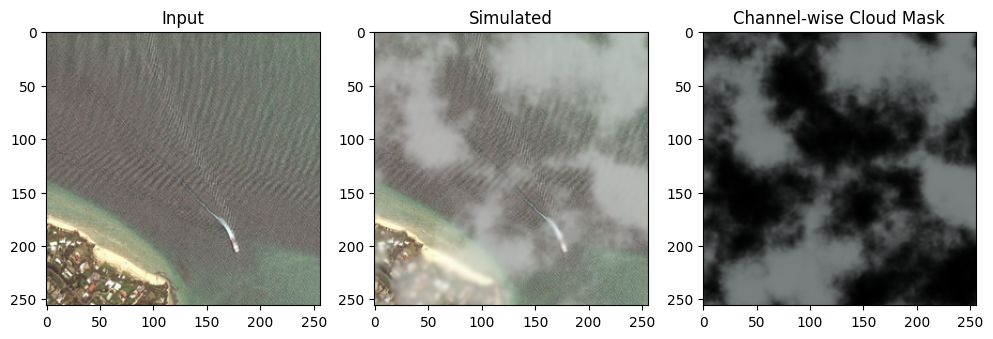

In [17]:
# By setting blur_scaling argument to a value different than 0.0, a locally varying Gaussian blur can be applied. The standard deviation is proportional to the cloud strength (ranging between 0 and 1) multplied by the blur_scaling factor.
cl, mask = scg.add_cloud(rgb_img,
                     min_lvl=0.0,
                     max_lvl=0.5,
                     cloud_color=False,
                     channel_offset=0,
                     blur_scaling=4.0,
                     return_cloud=True
                    )

plot_clouds(rgb_img, cl, mask)

## Clouds and Shadows

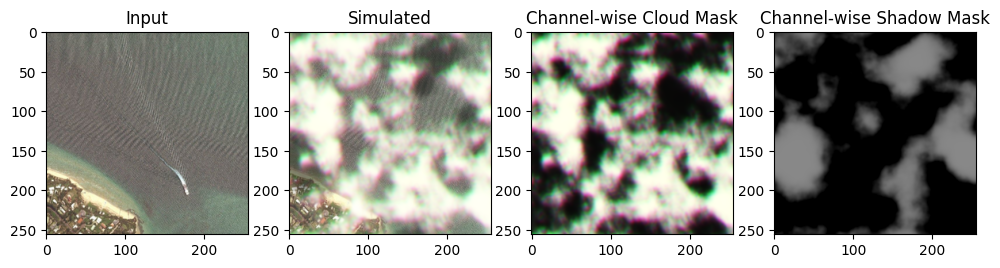

In [18]:
cl, cmask, smask = scg.add_cloud_and_shadow(rgb_img,
                                        return_cloud=True
                                       )

plot_clouds(rgb_img, cl, cmask, smask)


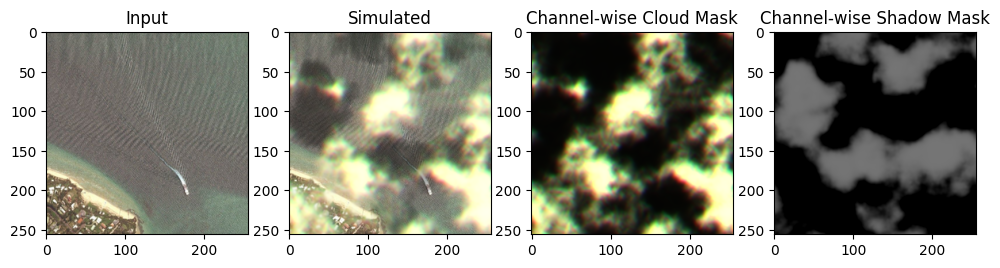

In [19]:
# You can set channel_magnitude_shift to achieve slightly different cloud strengths depending on the channel.
# (For visualization, this effect has been made quite extreme here)
cl, cmask, smask = scg.add_cloud_and_shadow(rgb_img,
                                        locality_degree=2,
                                        channel_magnitude_shift=0.5,
                                        return_cloud=True
                                       )

plot_clouds(rgb_img, cl, cmask, smask)